## Filter Timescales of SIT Variability and Covariability

In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as signal
from functools import partial
import seaborn as sns 

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import glob
import pandas as pd

In [2]:
def partition_timescales(data, sample_freq):
    
    years = len(data.time)/sample_freq
    
    anomalies = get_monthly_anomalies(data)
    filtered_data = butterworth_filter2(sample_freq, years, anomalies)
    
    variability = filtered_data #.std(dim = 'time')
    # sit_sic_cov = xr.cov(filtered_data.sithick, filtered_data.siconc, dim = 'time')
#     siv_sia_cov = xr.cov(filtered_data.SIV, filtered_data.SIA, dim = 'time')
    
    # variability['sit_sic_cov'] = sit_sic_cov
#     variability['siv_sia_cov'] = siv_sia_cov
    
    return variability

In [3]:
def butterworth_filter2(sample_freq, years, anomalies):
    
    # set up cutoffs
    nyquist = 1/2
    nints = sample_freq * years
    dec_cutoff = 1/nints * 1/nyquist
    a2d_cutoff = 1/(sample_freq*1.5) * 1/nyquist
    ann_cutoff = 1/(sample_freq*0.5) * 1/nyquist
    
    # form filters
    s2s_sos = signal.butter(4, ann_cutoff, 'hp', output='sos')
    ann_sos = signal.butter(4, [a2d_cutoff, ann_cutoff], 'bp', output='sos')
    a2d_sos = signal.butter(4, a2d_cutoff, 'lp', output='sos')
    
    # perform filtering
    s2s_filt = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    ann_filt = xr.apply_ufunc(partial(signal.sosfilt, ann_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    a2d_filt = xr.apply_ufunc(partial(signal.sosfilt, a2d_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    
    # concatenate
    filtered_data = xr.concat([s2s_filt, ann_filt, a2d_filt], dim = 'timescale')
    
    # assign coordinates
    filtered_data = filtered_data.assign_coords({'timescale':['s2s','ann','a2d']})
    
    return filtered_data

In [4]:
def butterworth_filter4(sample_freq, years, anomalies):
    
    # set up cutoffs
    nyquist = 1/2
    nints = sample_freq * years
    dec_cutoff = 1/nints * 1/nyquist
    a2d_cutoff = 1/(sample_freq*1.5) * 1/nyquist
    ann_cutoff = 1/(sample_freq*0.5) * 1/nyquist
    
    # form filters
    s2s_sos = signal.butter(4, ann_cutoff, 'hp', output='sos')
    ann_sos = signal.butter(4, [a2d_cutoff, ann_cutoff], 'bp', output='sos')
    a2d_sos = signal.butter(4, [dec_cutoff, a2d_cutoff], 'bp', output='sos')
    dec_sos = signal.butter(4, dec_cutoff, 'lp', output='sos')
    
    # perform filtering
    s2s_filt = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    ann_filt = xr.apply_ufunc(partial(signal.sosfilt, ann_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    a2d_filt = xr.apply_ufunc(partial(signal.sosfilt, a2d_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    dec_filt = xr.apply_ufunc(partial(signal.sosfilt, dec_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    
    # concatenate
    filtered_data = xr.concat([s2s_filt, ann_filt, a2d_filt, dec_filt], dim = 'timescale')
    
    # assign coordinates
    filtered_data = filtered_data.assign_coords({'timescale':['s2s','ann','a2d','dec']})
    
    return filtered_data

In [5]:
def get_monthly_anomalies(new_data):

    climat = new_data.groupby('time.month').mean(dim='time', skipna=True)
    anoms = new_data.groupby('time.month') - climat 

    return anoms

In [6]:
def convert_coords(lat, lon, og_data, ccrs_grid):
    """ convert data to appropriate coordinates for ccrs plot """
    
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

def fashion_space(ax):
    """ set standard design paramaters for hemispheric stereo plots """
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
def plot_nps(data_array, bounds, cmap, ax):
    """ plot a NorthPolarStereo map """
    
    data = data_array
    lat = data_array.latitude
    lon = data_array.longitude
    nps = ccrs.NorthPolarStereo()
    
    xs,ys,plot_data=convert_coords(lat, lon, data, nps)
    
    # fig = plt.figure(figsize = (6,6))
    # ax = plt.gca() #axes(projection=nps)
    fashion_space(ax)
    # cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(bounds[0], bounds[1], 6)
    clevs = np.linspace(bounds[0], bounds[1], 16)
    img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

In [7]:
def smooth_to_monthly(data):
    
    time = pd.date_range(start=str(data.time[0].values)[0:10], end = str((data.time[-1] + pd.to_timedelta(30, unit='D')).values)[0:10], freq='M')
    YEAR = []
    for y in range(2011,2021):
        YEAR.append(thing[y].groupby('time.month').mean(dim='time'))
        
    new_data = xr.concat(YEAR, dim = 'month')
    new_data['month'] = time
    new_data = new_data.rename({'month':'time'})
    
    return new_data

# CS2

In [8]:
file = '../data/cryosat-2/cryosat-2/cs2_landy_data.nc'
data = xr.open_dataset(file)

# limit to 2011-2020 (get rid of nasty residual tracks in 2010)
data = data.isel(time = slice(6, -1))
data['siconc'] = data.siconc.where(np.isnan(data.siconc) != True, 0)
data['sithick'] = data.sithick.where(np.isnan(data.sithick) != True, 0)
data['siarea'] = data.siarea.where(np.isnan(data.siarea) != True, 0)
data['sivol'] = data.sivol.where(np.isnan(data.sivol) != True, 0)

# data = smooth_to_monthly(data)

### Grid Cell Standard Deviation of Thickness Plots

In [9]:
variability = partition_timescales(data, 12)

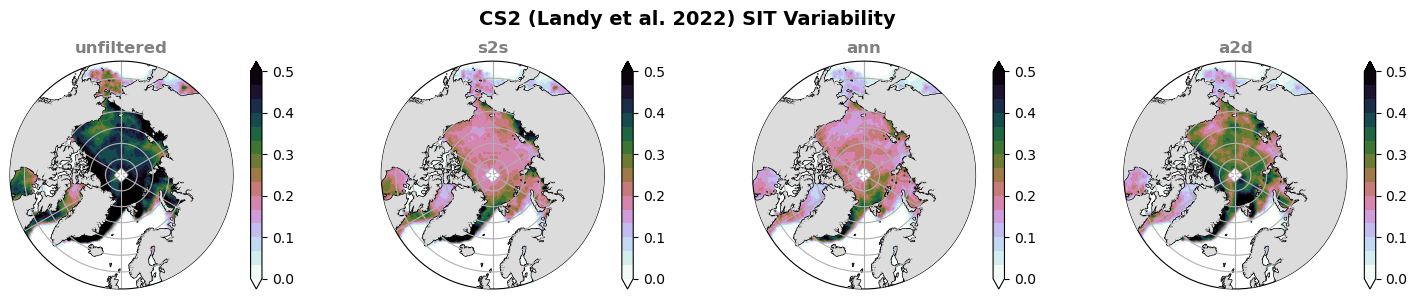

In [10]:
fig, axes = plt.subplots(ncols = 4, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0, 4):
    ax = axes[i]
    if i == 0: 
        anomalies = get_monthly_anomalies(data)
        plot_nps(anomalies.sithick.std(dim='time'), [0, 0.5], plt.cm.cubehelix_r, ax)
        ax.set_title('unfiltered', fontweight='bold', fontsize=12, color = 'grey')
    else:
        plot_nps(variability.sithick[i-1].std(dim='time'), [0, 0.5], plt.cm.cubehelix_r, ax)
        ax.set_title(variability.timescale[i-1].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('CS2 (Landy et al. 2022) SIT Variability', fontweight = 'bold', fontsize=14)
plt.tight_layout()

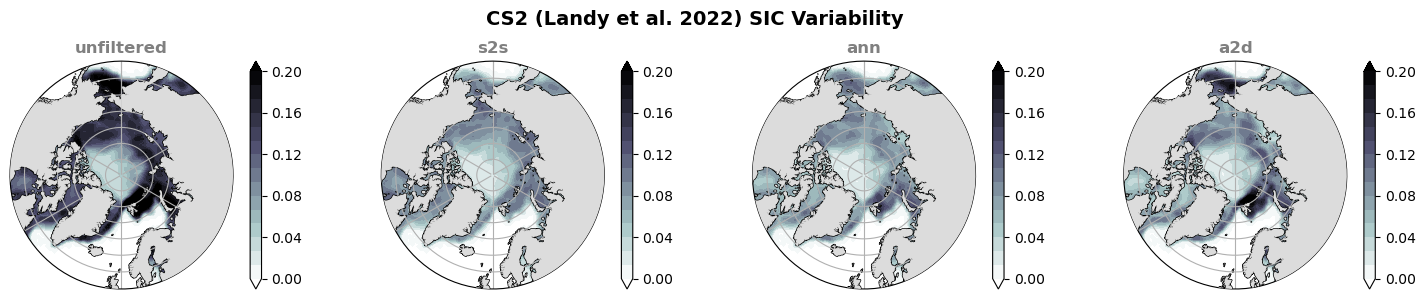

In [11]:
fig, axes = plt.subplots(ncols = 4, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0, 4):
    ax = axes[i]
    if i == 0: 
        anomalies = get_monthly_anomalies(data)
        plot_nps(anomalies.siconc.std(dim='time'), [0, 0.2], plt.cm.bone_r, ax)
        ax.set_title('unfiltered', fontweight='bold', fontsize=12, color = 'grey')
    else:
        plot_nps(variability.siconc[i-1].std(dim='time'), [0, 0.2], plt.cm.bone_r, ax)
        ax.set_title(variability.timescale[i-1].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('CS2 (Landy et al. 2022) SIC Variability', fontweight = 'bold', fontsize=14)
plt.tight_layout()

In [12]:
anomalies = get_monthly_anomalies(data)

In [13]:
anomalies['sit_sic_cov'] = xr.cov(anomalies.sithick, anomalies.siconc, dim = 'time')

In [14]:
variability['sit_sic_cov'] = xr.cov(variability.sithick, variability.siconc, dim = 'time')

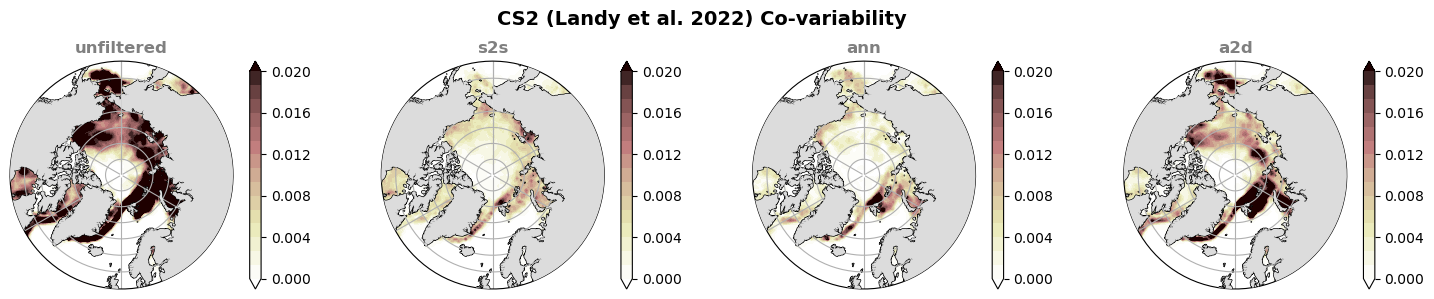

In [15]:
fig, axes = plt.subplots(ncols = 4, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0, 4):
    ax = axes[i]
    if i == 0: 
        plot_nps(anomalies.sit_sic_cov, [0, 0.02], plt.cm.pink_r, ax)
        ax.set_title('unfiltered', fontweight='bold', fontsize=12, color = 'grey')
    else:
        plot_nps(variability.sit_sic_cov[i-1], [0, 0.02], plt.cm.pink_r, ax)
        ax.set_title(variability.timescale[i-1].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('CS2 (Landy et al. 2022) Co-variability', fontweight = 'bold', fontsize=14)
plt.tight_layout()

### Correlation and composition maps

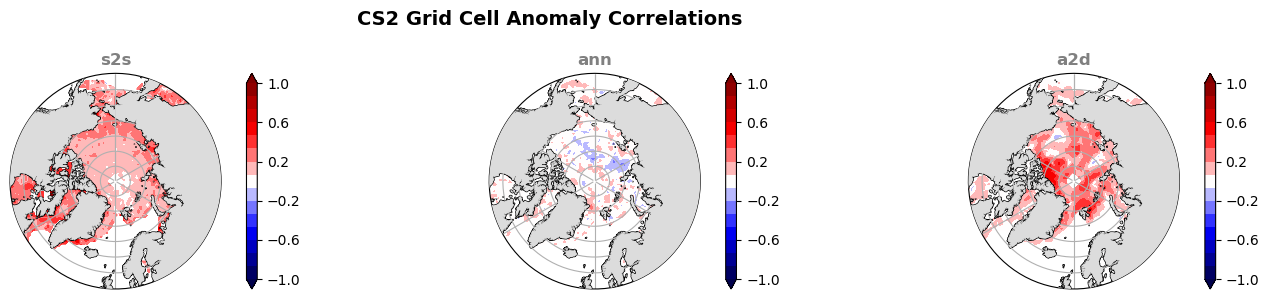

In [16]:
fig, axes = plt.subplots(ncols = 3 , nrows=1, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,3):
    ptxpt = xr.corr(anomalies.sithick, variability.sithick[i], dim = 'time')
    plot_nps(ptxpt,[-1, 1], plt.cm.seismic, axes[i])
    axes[i].set_title(variability.timescale[i].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('CS2 Grid Cell Anomaly Correlations', fontweight = 'bold', fontsize=14)
plt.tight_layout()   

# PIOMAS

In [17]:
file = '/glade/work/mollyw/Projects/sea_ice_covariability/data/cryosat-2/piomas/piomas_biweekly_data.nc'
pdata = xr.open_dataset(file)

# limit to 2011-2020 (get rid of nasty residual tracks in 2010)
pdata = pdata.isel(time = slice(6, -1))
pdata['siconc'] = pdata.siconc.where(np.isnan(pdata.siconc) != True, 0)
pdata['sithick'] = pdata.sithick.where(np.isnan(pdata.sithick) != True, 0)
pdata['siarea'] = pdata.siarea.where(np.isnan(pdata.siarea) != True, 0)
pdata['sivol'] = pdata.sivol.where(np.isnan(pdata.sivol) != True, 0)

# pdata = smooth_to_monthly(pdata)

In [18]:
pvariability = partition_timescales(pdata, 24)

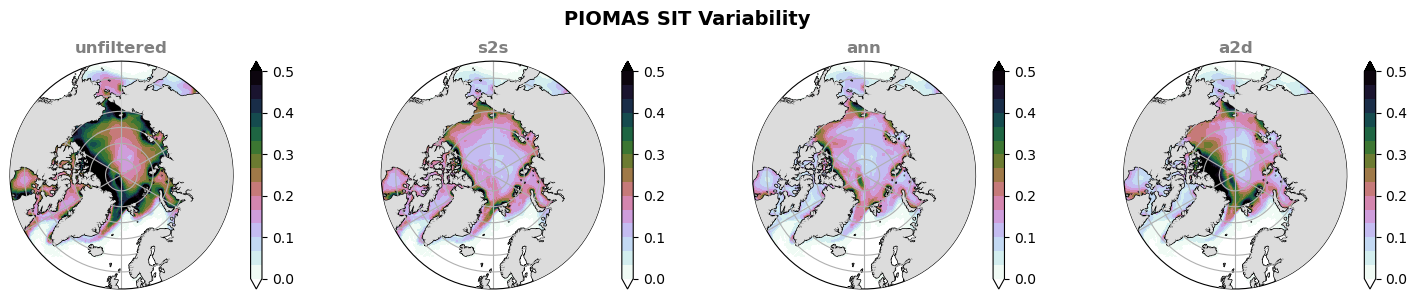

In [19]:
fig, axes = plt.subplots(ncols = 4, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0, 4):
    ax = axes[i]
    if i == 0: 
        panomalies = get_monthly_anomalies(pdata)
        plot_nps(panomalies.sithick.std(dim='time'), [0, 0.5], plt.cm.cubehelix_r, ax)
        ax.set_title('unfiltered', fontweight='bold', fontsize=12, color = 'grey')
    else:
        plot_nps(pvariability.sithick[i-1].std(dim='time'), [0, 0.5], plt.cm.cubehelix_r, ax)
        ax.set_title(pvariability.timescale[i-1].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('PIOMAS SIT Variability', fontweight = 'bold', fontsize=14)
plt.tight_layout()

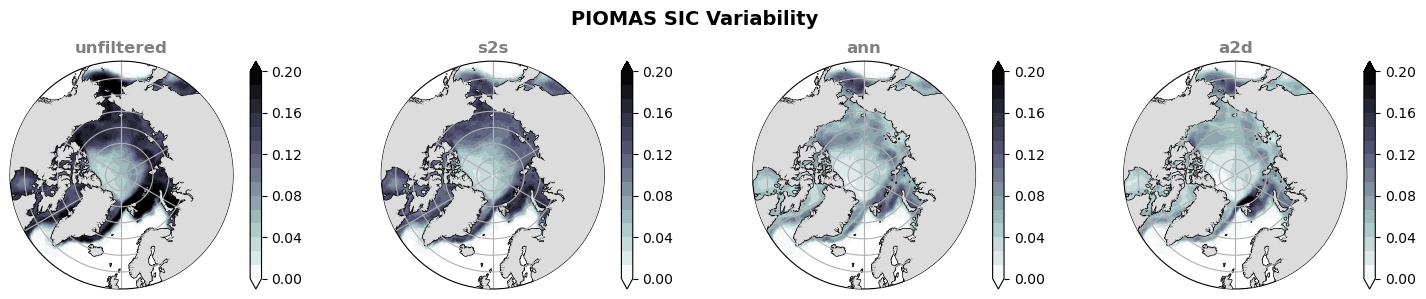

In [20]:
fig, axes = plt.subplots(ncols = 4, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0, 4):
    ax = axes[i]
    if i == 0: 
        panomalies = get_monthly_anomalies(pdata)
        plot_nps(panomalies.siconc.std(dim='time'), [0, 0.2], plt.cm.bone_r, ax)
        ax.set_title('unfiltered', fontweight='bold', fontsize=12, color = 'grey')
    else:
        plot_nps(pvariability.siconc[i-1].std(dim='time'), [0, 0.2], plt.cm.bone_r, ax)
        ax.set_title(pvariability.timescale[i-1].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('PIOMAS SIC Variability', fontweight = 'bold', fontsize=14)
plt.tight_layout()

In [21]:
panomalies = get_monthly_anomalies(pdata)
panomalies['sit_sic_cov'] = xr.cov(panomalies.sithick, panomalies.siconc, dim = 'time')
pvariability['sit_sic_cov'] = xr.cov(pvariability.sithick, pvariability.siconc, dim = 'time')

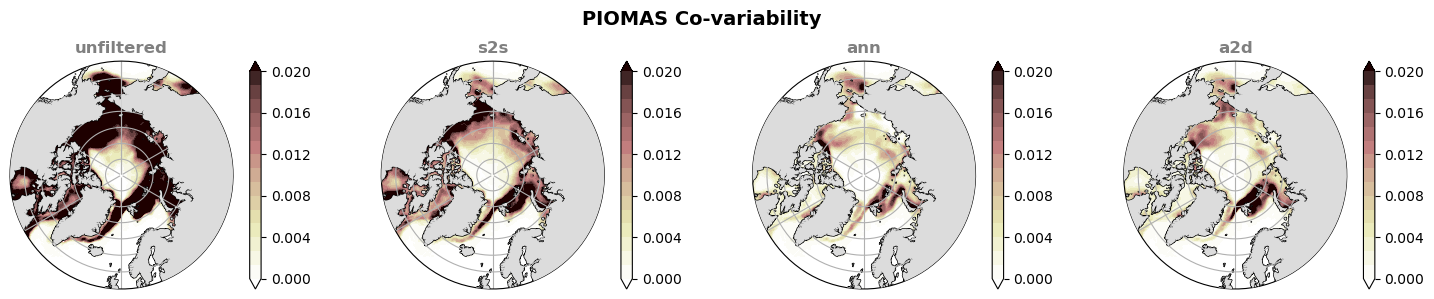

In [22]:
fig, axes = plt.subplots(ncols = 4, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0, 4):
    ax = axes[i]
    if i == 0: 
        plot_nps(panomalies.sit_sic_cov, [0, 0.02], plt.cm.pink_r, ax)
        ax.set_title('unfiltered', fontweight='bold', fontsize=12, color = 'grey')
    else:
        plot_nps(pvariability.sit_sic_cov[i-1], [0, 0.02], plt.cm.pink_r, ax)
        ax.set_title(pvariability.timescale[i-1].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('PIOMAS Co-variability', fontweight = 'bold', fontsize=14)
plt.tight_layout()

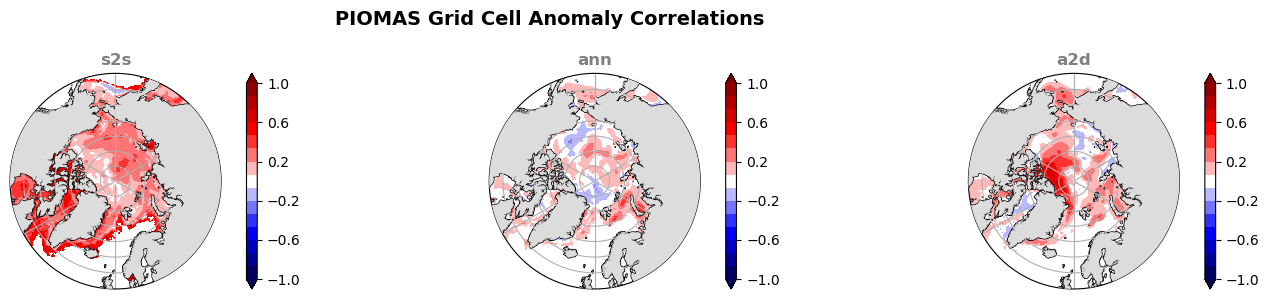

In [23]:
fig, axes = plt.subplots(ncols = 3, nrows=1, figsize=(15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,3):
    ptxpt = xr.corr(panomalies.sithick, pvariability.sithick[i], dim = 'time')
    plot_nps(ptxpt,[-1, 1], plt.cm.seismic, axes[i])
    axes[i].set_title(pvariability.timescale[i].values, fontweight='bold', fontsize=12, color = 'grey')

plt.suptitle('PIOMAS Grid Cell Anomaly Correlations', fontweight = 'bold', fontsize=14)
plt.tight_layout()   

# CMIP6

In [23]:
files = sorted(glob.glob('../data/cryosat-2/cmip6/monthly/*.nc'))

In [25]:
siv_sia = []
count = 1
for file in files:
    
    data = xr.open_dataset(file)
    data['siconc'] = data.siconc.where(np.isnan(data.siconc) != True, 0)
    data['sithick'] = data.sithick.where(np.isnan(data.sithick) != True, 0)
    data['siarea'] = data.siarea.where(np.isnan(data.siarea) != True, 0)
    data['sivol'] = data.sivol.where(np.isnan(data.sivol) != True, 0)
    
    if count == len(files):
        print('YEAH')
        data['sithick'] = data.sithick/100
        data['sivol'] = data.sivol/100
        data['SIV'] = data.SIV/100
    
    # variability = partition_timescales(data, 12)
    # variability['raw_sit'] = data.sithick.mean(dim='time')
    # variability['raw_sic'] = data.siconc.mean(dim='time')
    # variability['raw_sia'] = data.SIA.mean(dim='time')
    # variability['raw_siv'] = data.SIV.mean(dim='time')
    
    siv_sia.append(data)
    
    count += 1
 

YEAH


In [26]:
CMIP6 = xr.concat(siv_sia, dim = 'model')

In [27]:
names = ['ACCESS-CM2','ACCESS-ESM1', 'CESM2-FV2','CESM2-WACCM-FV2',
         'CESM2', 'CMCC-CM2-SR5', 'CMCC-ESM2','GFDL-CM4','GFDL-ESM4',
         'IPSL-CM5A2-INCA','MPI-ESM-1-2-HAM','MPI-ESM1-2-LR',
         'TaiESM1']

In [12]:
SIV_SIA['siv_reg'] = SIV_SIA.siv_sia_cov/SIV_SIA.SIV
SIV_SIA['sia_reg'] = SIV_SIA.siv_sia_cov/SIV_SIA.SIA
SIV_SIA['sit_reg'] = SIV_SIA.sit_sic_cov/SIV_SIA.sithick
SIV_SIA['sic_reg'] = SIV_SIA.sit_sic_cov/SIV_SIA.siconc

/glade/scratch/mollyw/ipykernel_183712/3690322378.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral', 13)


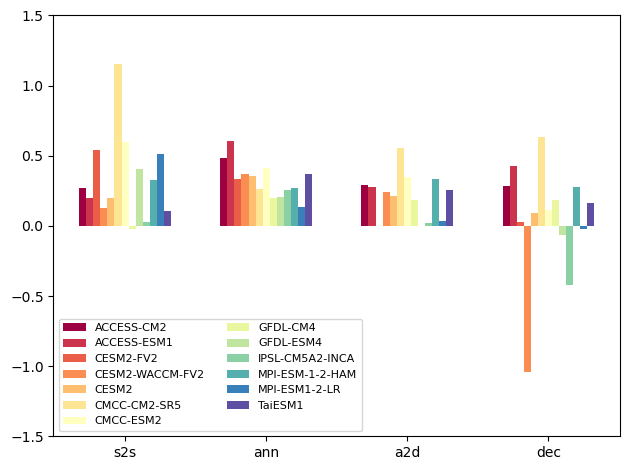

In [40]:
colors = plt.cm.get_cmap('Spectral', 13)

n = len(SIV_SIA.model)
w = .05
x = np.arange(0, len(SIV_SIA.timescale)) 

for i in range(0, 13):
    position = x + (w*(1-n)/2) + i*w
    plt.bar(position, SIV_SIA.siv_reg[i,:], width = w, label = names[i], color = colors(i)[:3])

plt.xticks([0,1,2,3], labels = SIV_SIA.timescale.values)
    
    # plt.scatter(x = SIV_SIA.timescale, y=SIV_SIA[i,:], c = colors(i)[:3], label = names[i])
plt.ylim([-1.5, 1.5])
plt.legend(fontsize=8, ncols = 2, loc = 'lower left')
plt.tight_layout()

/glade/scratch/mollyw/ipykernel_183712/412185648.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral', 13)


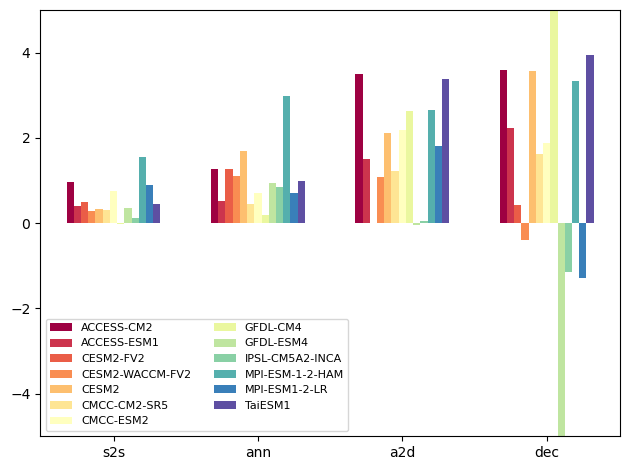

In [44]:
colors = plt.cm.get_cmap('Spectral', 13)

n = len(SIV_SIA.model)
w = .05
x = np.arange(0, len(SIV_SIA.timescale)) 

for i in range(0, 13):
    position = x + (w*(1-n)/2) + i*w
    plt.bar(position, SIV_SIA.sia_reg[i,:], width = w, label = names[i], color = colors(i)[:3])

plt.xticks([0,1,2,3], labels = SIV_SIA.timescale.values)
    
    # plt.scatter(x = SIV_SIA.timescale, y=SIV_SIA[i,:], c = colors(i)[:3], label = names[i])
plt.ylim([-5, 5])
plt.legend(fontsize=8, ncols = 2, loc = 'lower left')
plt.tight_layout()

In [13]:
SIV_SIA = SIV_SIA.stack({'space':['y','x']})

In [76]:
SIV_SIA = SIV_SIA.assign_coords({'model': names})

In [77]:
ACCESS_CM2= SIV_SIA.sel(model = 'ACCESS-CM2')

In [78]:
df = ACCESS_CM2.to_dataframe()

In [79]:
df = df.reset_index('timescale')

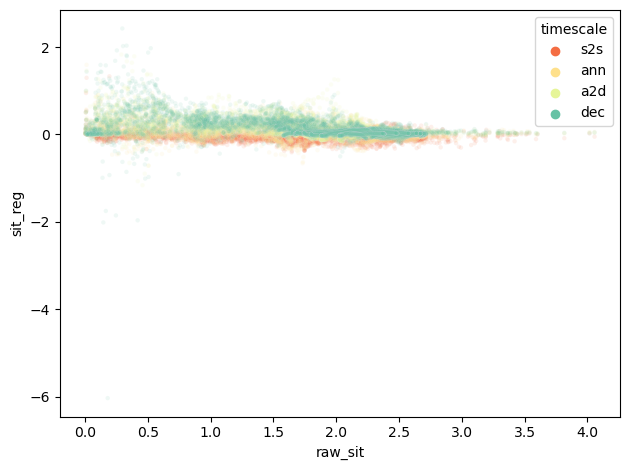

In [90]:
sns.scatterplot(data = df, x = df.raw_sit, y = df.sit_reg, hue = df.timescale, s = 10, palette='Spectral', alpha = 0.1)
# plt.ylim([-1,2])
# plt.xlim([0, 4.5])
plt.tight_layout()

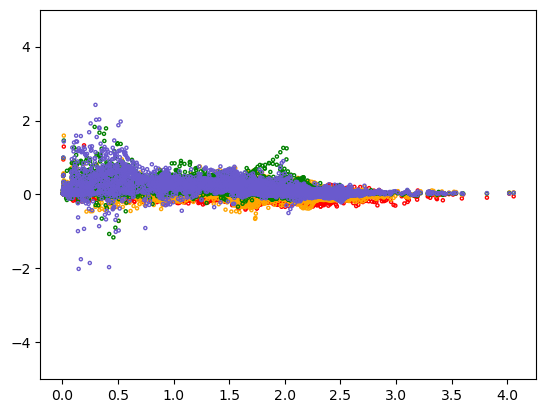

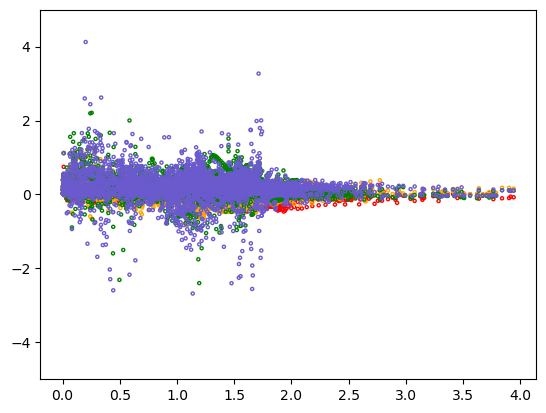

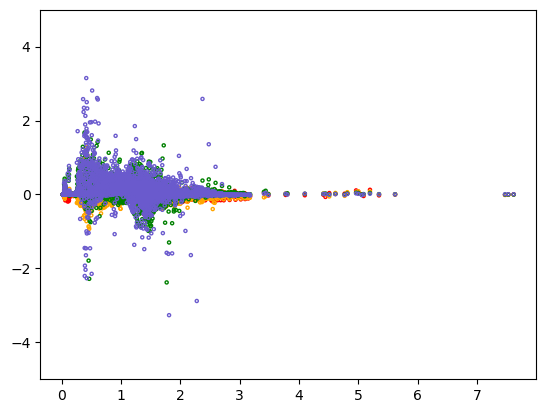

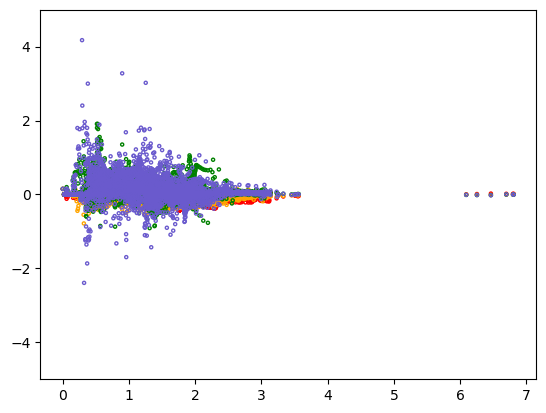

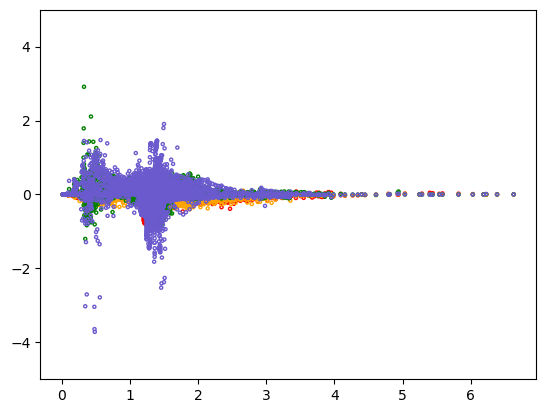

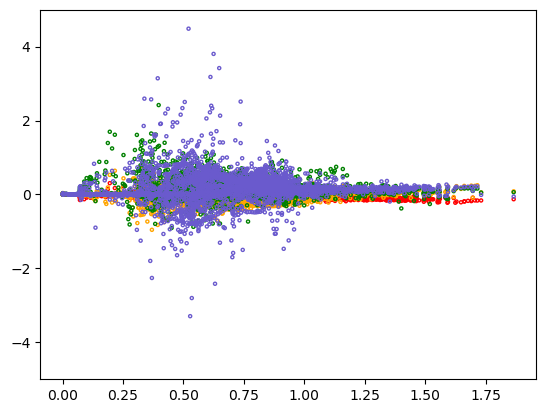

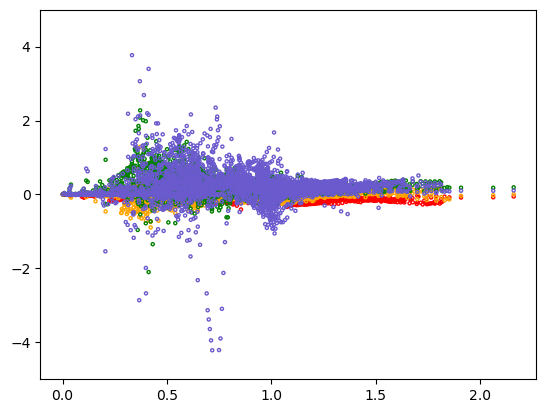

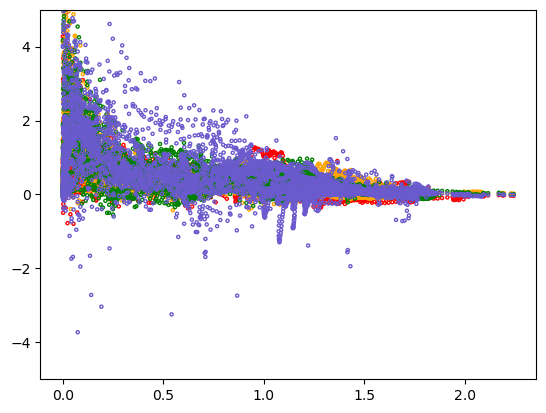

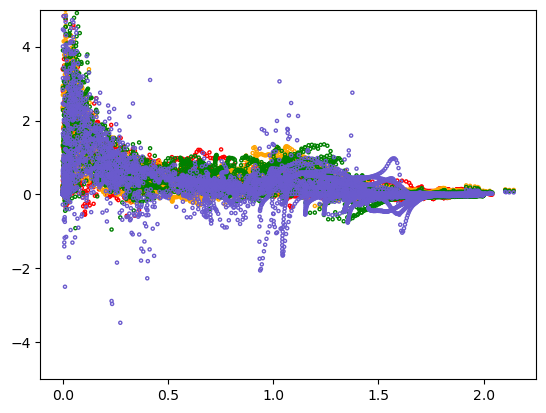

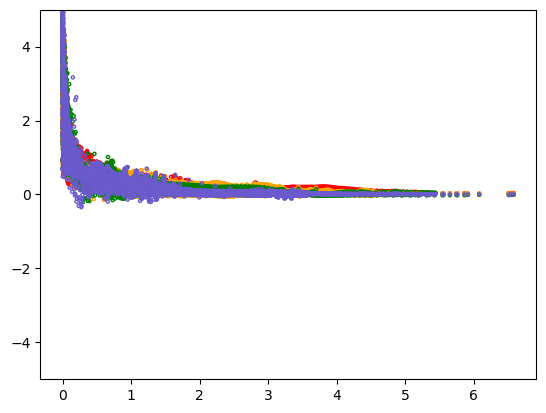

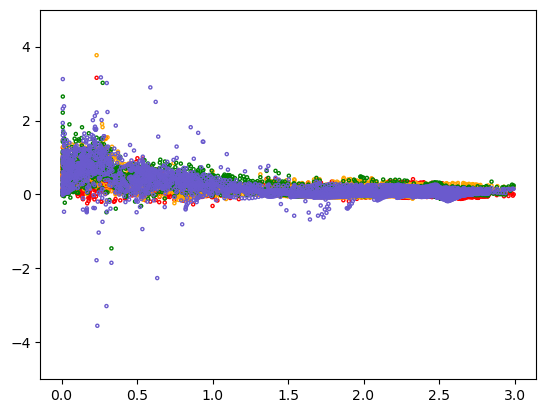

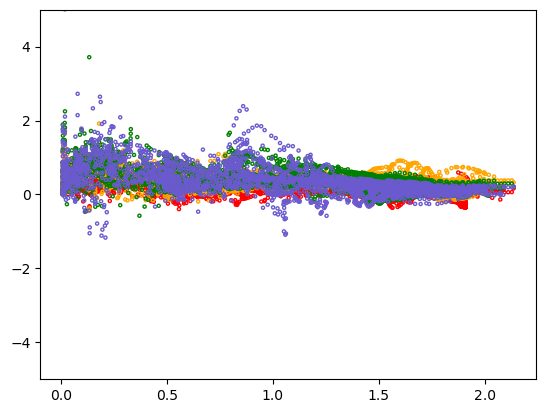

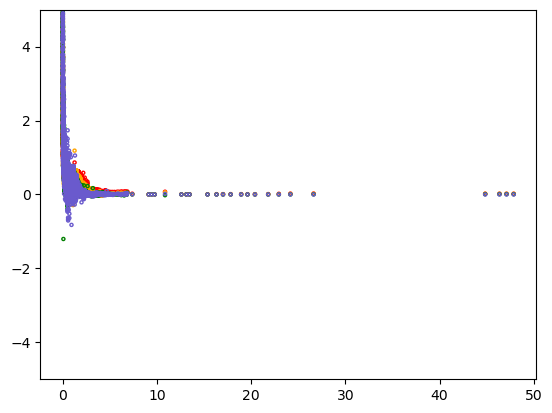

In [108]:
for i in range(0, 13):
    fig = plt.figure()
    plt.scatter(SIV_SIA.raw_sit[i], SIV_SIA.sel(timescale = 's2s').sit_reg[i], color = 'red', s = 5, facecolors='none')
    plt.scatter(SIV_SIA.raw_sit[i], SIV_SIA.sel(timescale = 'ann').sit_reg[i], color = 'orange', s =5, facecolors='none')
    plt.scatter(SIV_SIA.raw_sit[i], SIV_SIA.sel(timescale = 'a2d').sit_reg[i], color = 'green', s = 5, facecolors='none')
    plt.scatter(SIV_SIA.raw_sit[i], SIV_SIA.sel(timescale = 'dec').sit_reg[i], color = 'slateblue', s = 5, facecolors='none')
    plt.ylim([-5, 5])
    
    
# plt.scatter(

<BarContainer object of 4 artists>

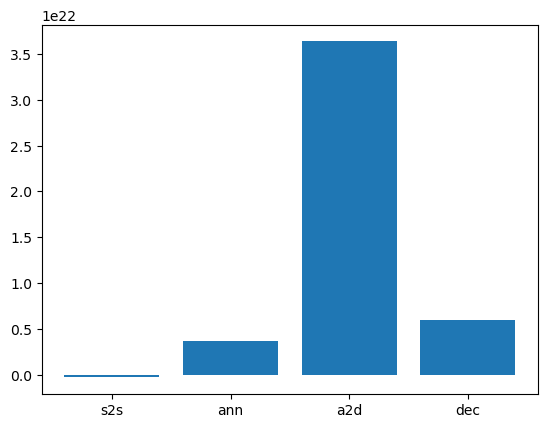

In [21]:
plt.bar(x= variability.timescale, height= variability.siv_sia_cov)

In [83]:
# var_data = var_data.rename({'latitude':'lat', 'longitude':'lon'})

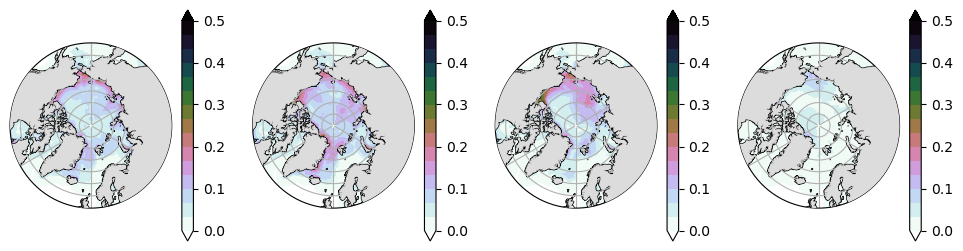

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4,
                         figsize=(12,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,4):
    ax = axes[i]
    plot_nps(variability.sithick[i], bounds = [0, 0.5], cmap = plt.cm.cubehelix_r, ax = ax)

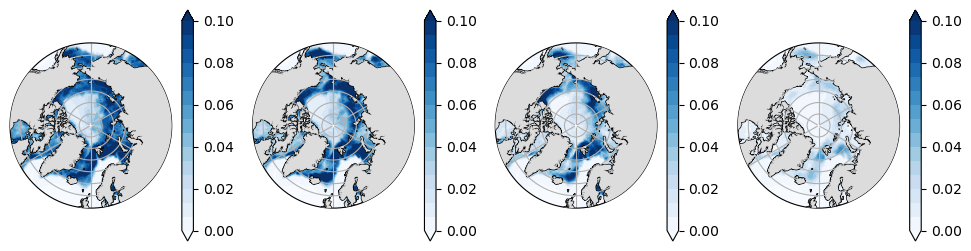

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4,
                         figsize=(12,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,4):
    ax = axes[i]
    plot_nps(variability.siconc[i], bounds = [0, 0.1], cmap = plt.cm.Blues, ax = ax)

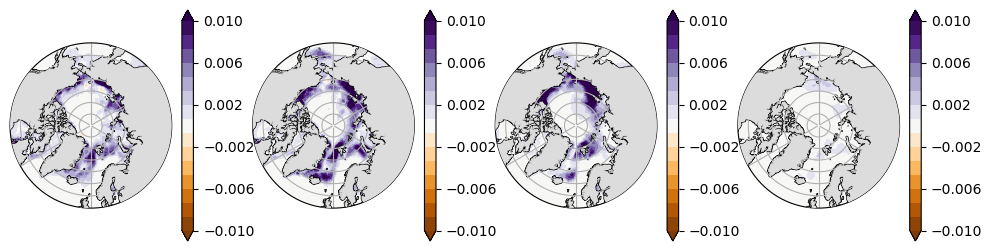

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=4,
                         figsize=(12,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,4):
    ax = axes[i]
    plot_nps(variability.sit_sic_cov[i], bounds = [-0.01, 0.01], cmap = plt.cm.PuOr, ax = ax)

# Monthly Variability

In [81]:
def partition_timescales(data, sample_freq):
    
    years = len(data.time)/sample_freq
    
    anomalies = get_monthly_anomalies(data)
    filtered_data = butterworth_filter(sample_freq, years, anomalies)
    
    variability = filtered_data #.std(dim = 'time')
    # sit_sic_cov = xr.cov(filtered_data.sithick, filtered_data.siconc, dim = 'time')
#     siv_sia_cov = xr.cov(filtered_data.SIV, filtered_data.SIA, dim = 'time')
    
    # variability['sit_sic_cov'] = sit_sic_cov
#     variability['siv_sia_cov'] = siv_sia_cov
    
    return variability

In [24]:
def variability_in_window(data, low, high, fs = 15):
    
    # determine filter
    nyquist = fs / 2
    # print('low cutoff= ',1/low*nyquist,' days')
    # print('high cutoff= ',1/high*nyquist,' days')
    
    sos = signal.butter(5, [low, high], btype='bandpass', output='sos')
    
    filtered = signal.sosfiltfilt(sos, data, axis = 0)
    filtered = xr.DataArray(filtered,
                            coords = data.coords,
                            dims = data.dims,
                            attrs = data.attrs
                           )
    hfsit = filtered.groupby('time.month').std(dim='time')
    
    return hfsit

In [41]:
anomalies = get_monthly_anomalies(data)
panomalies = get_monthly_anomalies(pdata)

In [38]:
anomalies = anomalies.rolling(time=2).mean()

In [39]:
panomalies = panomalies.rolling(time=2).mean()

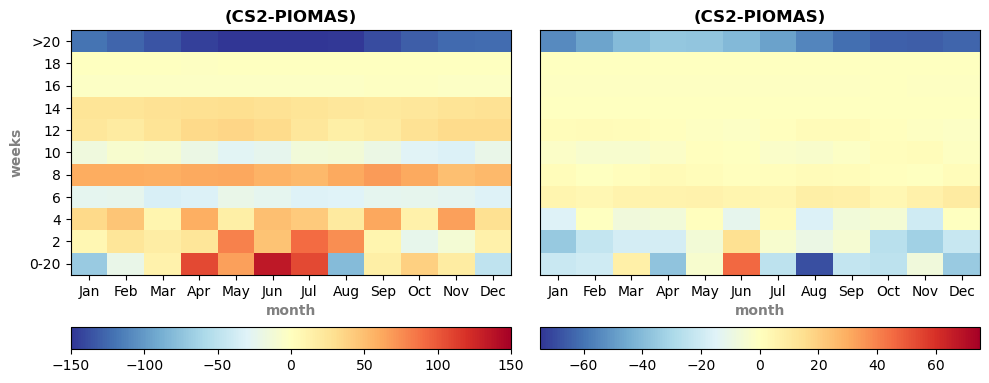

In [45]:
cutoffs= [1/2, 1/4, 1/6, 1/8, 1/10, 1/12, 1/14, 1/16, 1/18, 1/20, 1/52]

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# months = ['DJF','MAM','JJA','SON']
days = [0,2,4,6,8,10,12,14,16,18,20]

# initalize list for each window
list_hfsiv = []
list_hfsia = []

hfsiv = variability_in_window(anomalies.SIV/(1000**3), 1/20, 1/2, fs = 15)
hfsia = variability_in_window(anomalies.SIA/(1000**3), 1/20, 1/2, fs = 15)
phfsiv = variability_in_window(panomalies.SIV/(1000**3), 1/20, 1/2, fs = 15)
phfsia = variability_in_window(panomalies.SIA/(1000**3), 1/20, 1/2, fs = 15)

list_hfsiv.append(hfsiv-phfsiv)
list_hfsia.append(hfsia-phfsia)

# solve each window and append to list
for i in range(0, len(cutoffs[:-1])):
    hfsiv = variability_in_window(anomalies.SIV/(1000**3), cutoffs[i+1], cutoffs[i], fs = 15)
    hfsia = variability_in_window(anomalies.SIA/(1000**3), cutoffs[i+1], cutoffs[i], fs = 15)
    phfsiv = variability_in_window(panomalies.SIV/(1000**3), cutoffs[i+1], cutoffs[i], fs = 15)
    phfsia = variability_in_window(panomalies.SIA/(1000**3), cutoffs[i+1], cutoffs[i], fs = 15)
    list_hfsiv.append(hfsiv-phfsiv)
    list_hfsia.append(hfsia-phfsia)

# combine records 
HFSIV = xr.concat(list_hfsiv, dim = 'intervals')
HFSIA = xr.concat(list_hfsia, dim = 'intervals')


fig, axes = plt.subplots(ncols = 2, figsize=(10,4))

cmap_siv = plt.cm.RdYlBu_r
cmap_sia = plt.cm.RdYlBu_r

im1 = axes[0].pcolormesh(months, days, HFSIV, vmin = -150, vmax = 150, cmap = cmap_siv)
axes[0].set_title('(CS2-PIOMAS)', fontweight = 'bold', fontsize =12)

im2 = axes[1].pcolormesh(months, days, HFSIA, vmin = -75, vmax = 75, cmap = cmap_sia)
axes[1].set_title('(CS2-PIOMAS)', fontweight = 'bold', fontsize =12)
plt.colorbar(im1, ax = axes[0], orientation = 'horizontal')
plt.colorbar(im2, ax = axes[1], orientation = 'horizontal')

axes[0].set_yticks([0,2,4,6,8,10,12,14,16,18,20])
axes[0].set_yticklabels(['0-20','2','4','6','8','10','12','14','16','18','>20'])
axes[0].set_ylabel('weeks', fontweight='bold', color ='grey')
axes[0].set_xlabel('month', fontweight='bold', color = 'grey')
axes[1].set_xlabel('month', fontweight='bold', color = 'grey')
axes[1].set_yticks([])
axes[1].set_yticklabels([])
plt.tight_layout()

In [41]:
names = ['ACCESS-CM2','ACCESS-ESM1', 'CESM2-FV2','CESM2-WACCM-FV2',
         'CESM2', 'CMCC-CM2-SR5', 'CMCC-ESM2','GFDL-CM4','GFDL-ESM4',
         'IPSL-CM5A2-INCA','MPI-ESM-1-2-HAM','MPI-ESM1-2-LR',
         'TaiESM1']

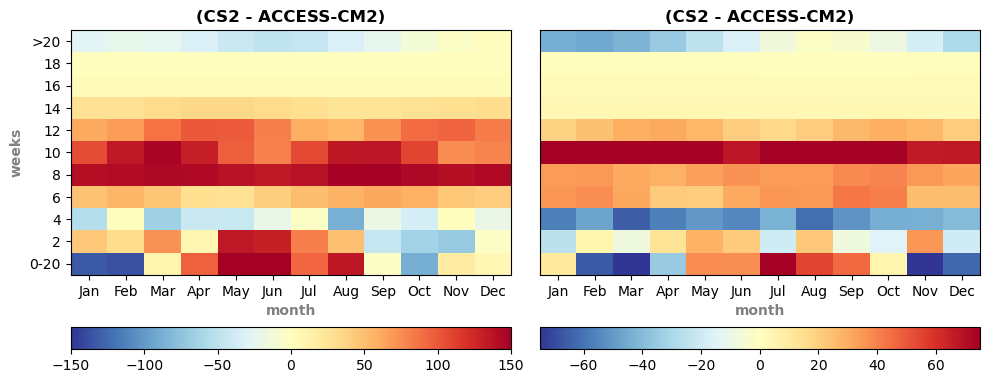

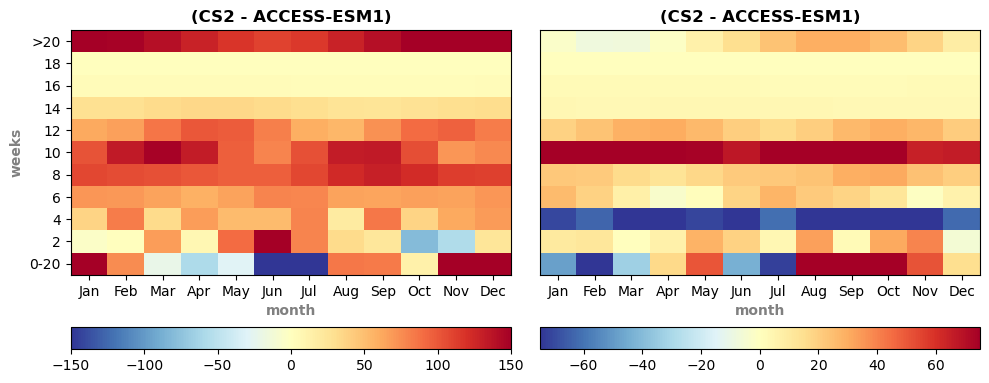

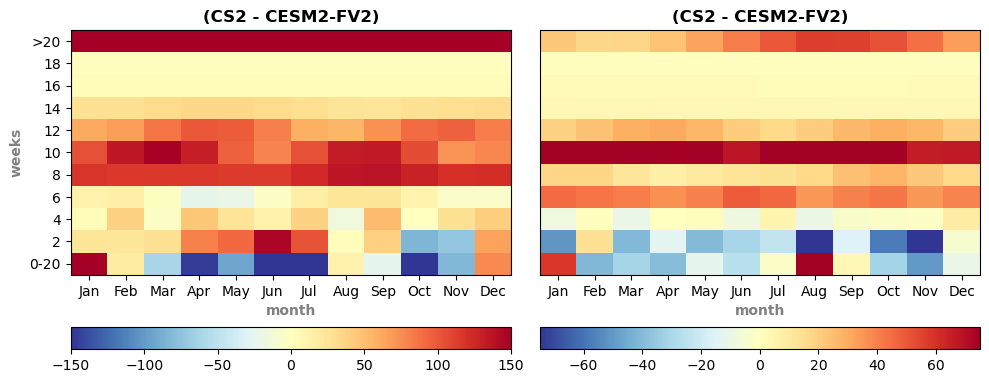

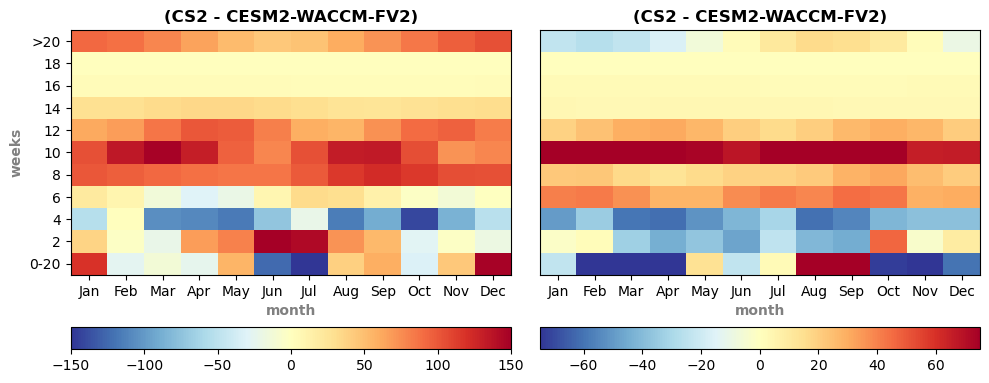

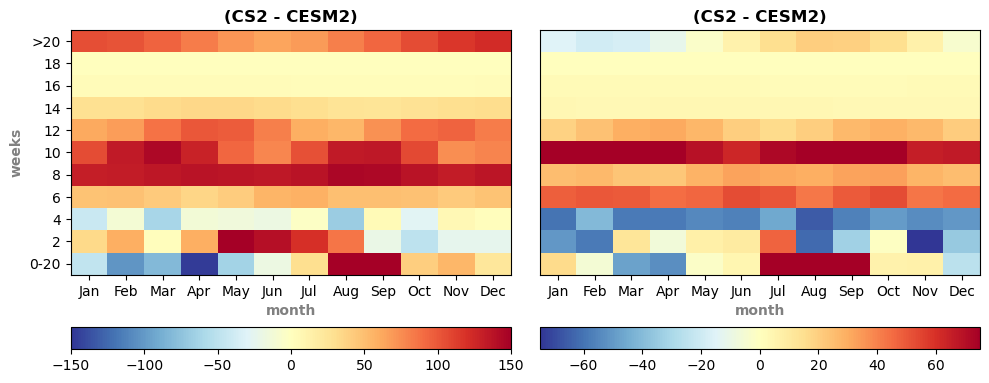

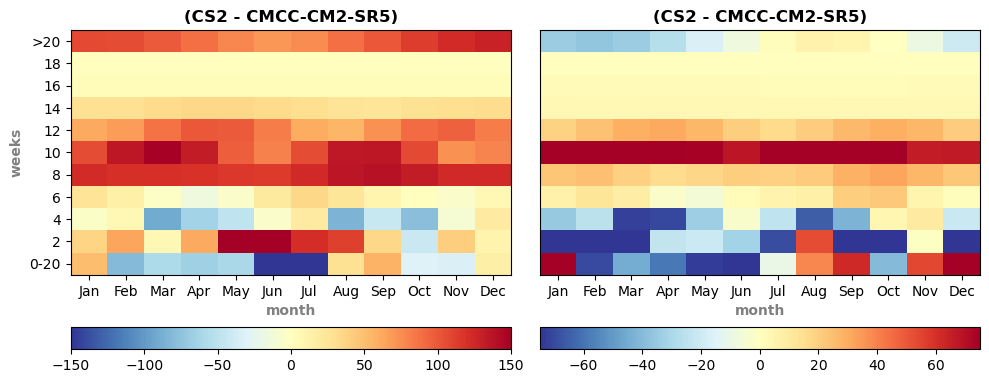

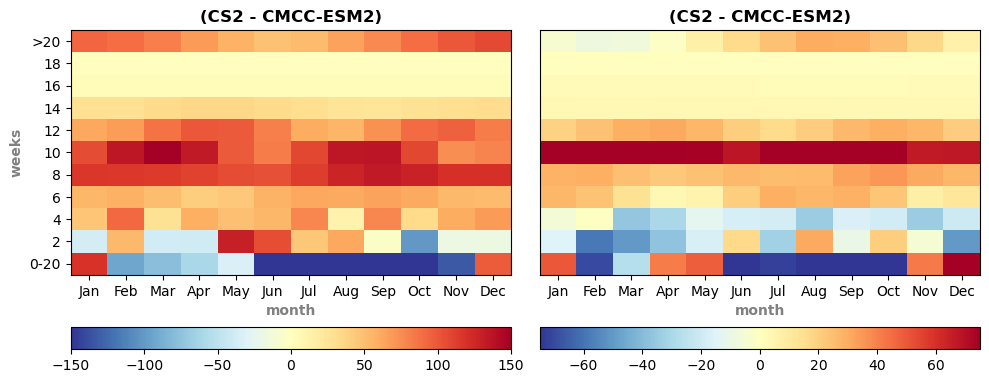

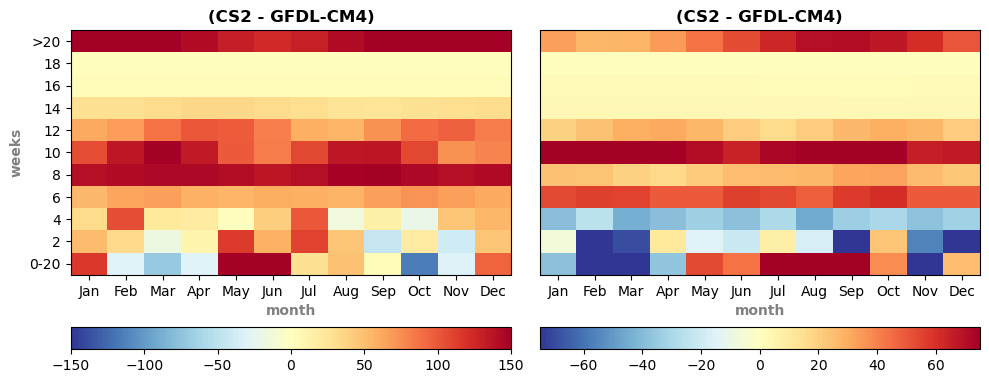

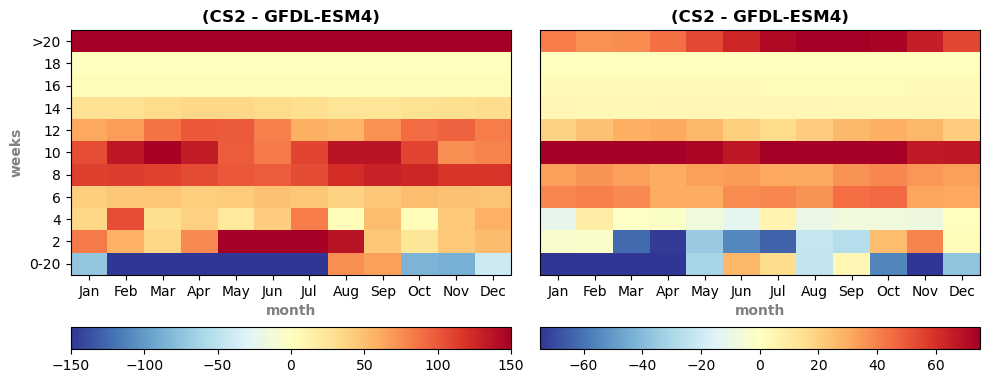

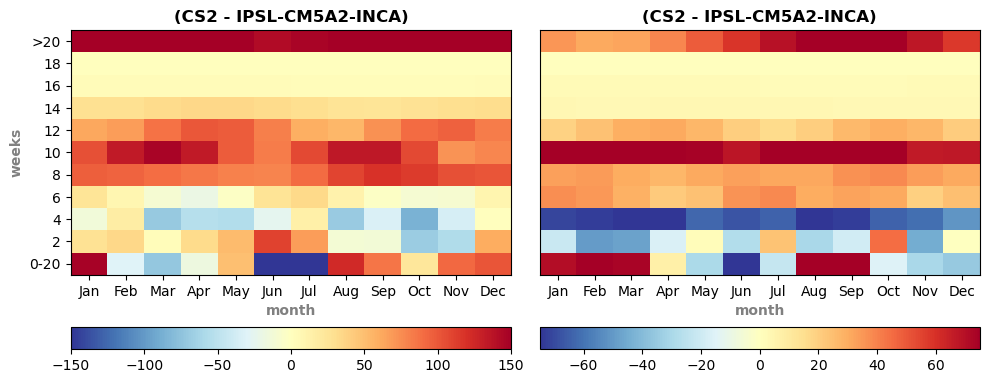

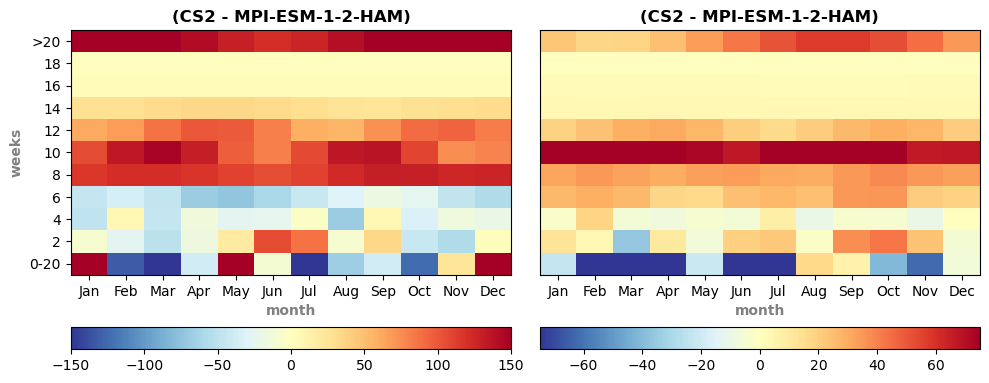

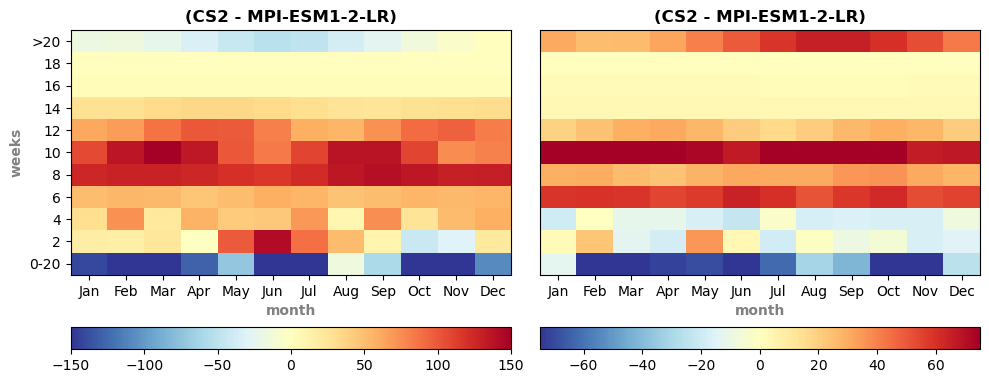

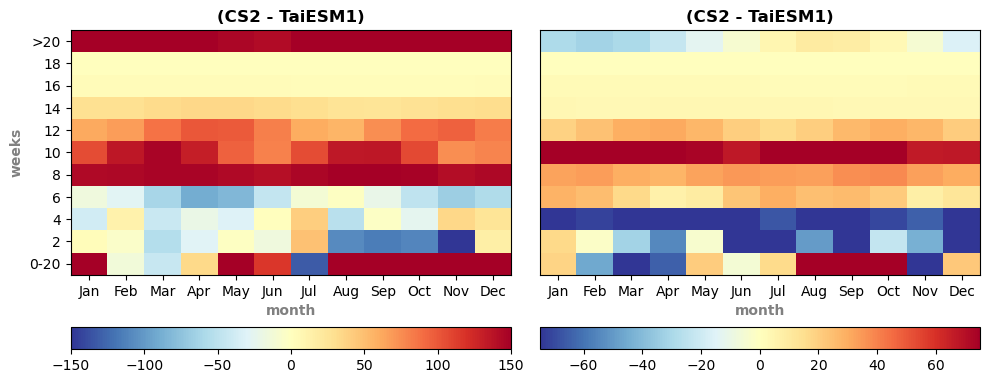

In [42]:
for j in range(0, len(CMIP6.model)):
    
    SIV_data = CMIP6.SIV[j]
    SIA_data = CMIP6.SIA[j]
    
    SIV_anomalies = get_monthly_anomalies(SIV_data)
    SIA_anomalies = get_monthly_anomalies(SIA_data)
    
    cutoffs= [1/2, 1/4, 1/6, 1/8, 1/10, 1/12, 1/14, 1/16, 1/18, 1/20, 1/52]

    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    # months = ['DJF','MAM','JJA','SON']
    days = [0,2,4,6,8,10,12,14,16,18,20]

    # initalize list for each window
    list_hfsiv = []
    list_hfsia = []

    hfsiv = variability_in_window(SIV_anomalies/(1000**3), 1/20, 1/2, fs = 30)
    hfsia = variability_in_window(SIA_anomalies/(1000**3), 1/20, 1/2, fs = 30)
    phfsiv = variability_in_window(anomalies.SIV/(1000**3), 1/20, 1/2, fs = 30)
    phfsia = variability_in_window(anomalies.SIA/(1000**3), 1/20, 1/2, fs = 30)

    list_hfsiv.append(hfsiv-phfsiv)
    list_hfsia.append(hfsia-phfsia)

    # solve each window and append to list
    for i in range(0, len(cutoffs[:-1])):
        hfsiv = variability_in_window(SIV_anomalies/(1000**3), cutoffs[i+1], cutoffs[i], fs = 30)
        hfsia = variability_in_window(SIA_anomalies/(1000**3), cutoffs[i+1], cutoffs[i], fs = 30)
        phfsiv = variability_in_window(anomalies.SIV/(1000**3), cutoffs[i+1], cutoffs[i], fs = 30)
        phfsia = variability_in_window(anomalies.SIA/(1000**3), cutoffs[i+1], cutoffs[i], fs = 30)
        list_hfsiv.append(phfsiv-hfsiv)
        list_hfsia.append(phfsia-hfsia)

        # combine records 
    HFSIV = xr.concat(list_hfsiv, dim = 'intervals')
    HFSIA = xr.concat(list_hfsia, dim = 'intervals')


    fig, axes = plt.subplots(ncols = 2, figsize=(10,4))

    cmap_siv = plt.cm.RdYlBu_r
    cmap_sia = plt.cm.RdYlBu_r

    im1 = axes[0].pcolormesh(months, days, HFSIV, vmin = -150, vmax = 150, cmap = cmap_siv)
    axes[0].set_title('(CS2 - '+names[j]+')', fontweight = 'bold', fontsize =12)

    im2 = axes[1].pcolormesh(months, days, HFSIA, vmin = -75, vmax = 75, cmap = cmap_sia)
    axes[1].set_title('(CS2 - '+names[j]+')', fontweight = 'bold', fontsize =12)
    plt.colorbar(im1, ax = axes[0], orientation = 'horizontal')
    plt.colorbar(im2, ax = axes[1], orientation = 'horizontal')

    axes[0].set_yticks([0,2,4,6,8,10,12,14,16,18,20])
    axes[0].set_yticklabels(['0-20','2','4','6','8','10','12','14','16','18','>20'])
    axes[0].set_ylabel('weeks', fontweight='bold', color ='grey')
    axes[0].set_xlabel('month', fontweight='bold', color = 'grey')
    axes[1].set_xlabel('month', fontweight='bold', color = 'grey')
    axes[1].set_yticks([])
    axes[1].set_yticklabels([])
 
    plt.tight_layout()